In [3]:
from reddy_replication_torch.config import config
from reddy_replication_torch.experiment import main, eval_loss_and_accuracy, calculate_induction_strength
from reddy_replication_torch.model import Transformer
import torch
from datasets.reddy.datasets_v2 import generate_input_seqs_TI, get_mus_label_class
import os
import numpy as np
import matplotlib.pyplot as plt
import wandb
import jax.numpy as jnp
from itertools import product
from plotting_utils import TI_per_pair_plot
from sklearn.decomposition import PCA
import seaborn as sns

sns.set_context("paper", font_scale=3)


In [4]:
config.save_model = True
config.model.out_dim = config.data.L
config.model.n_heads = 8
config.train.niters = 4000*10 + 1
config.model.w_init_scale=1

config.model.n_blocks=2
config.model.softmax_attn = [True] * config.model.n_blocks
config.model.include_mlp = [False] * config.model.n_blocks

In [5]:
# load pytorch model from checkpoint
config.model_dir = f'models/icl/model_h{config.model.n_heads}'
chosen_checkpoint = 40000
model_path = os.path.join(config.model_dir, f'cat_I{config.train.niters}_K1024_N12_L32_D63_a0.0_B1_pB1.0_pC1.0_eps0_lr0.01_drop0.0_custom_lnFalse_wDecay1e-07_adam_i{chosen_checkpoint}.pt')
if not os.path.exists(model_path):
    print('Model not found. Running experiment to train model.')
    main(config)
# load model
model = Transformer(config=config.model)
model.load_state_dict(torch.load(model_path))
wandb.finish()

In [6]:
model_path

'models/icl/model_h8/cat_I40001_K1024_N12_L32_D63_a0.0_B1_pB1.0_pC1.0_eps0_lr0.01_drop0.0_custom_lnFalse_wDecay1e-07_adam_i40000.pt'

In [7]:
# mp = os.path.join('models/icl/model_h2', 'cat_I40000_K1024_N12_L32_D63_a0.0_B1_pB1.0_pC1.0_eps0_lr0.01_drop0.0_custom_lnFalse_wDecay1e-07_adam_i12000.pt')

In [8]:
model_path

'models/icl/model_h8/cat_I40001_K1024_N12_L32_D63_a0.0_B1_pB1.0_pC1.0_eps0_lr0.01_drop0.0_custom_lnFalse_wDecay1e-07_adam_i40000.pt'

In [9]:
# eval data
S = config.data.S
K = config.data.K  # number of classes
L = config.data.L  # number of labels
D = config.data.D  # dimension of inputs
alpha = config.data.alpha  # zipf exponent
eps = config.data.eps  # within-class variance
# sequence parameters
N = config.seq.N
B = config.seq.B
pB = config.seq.pB
pC = config.seq.pC
Nmax = config.seq.Nmax  # this is fixed.
no_repeats = config.seq.no_repeats

mus_label, mus_class, labels_class = get_mus_label_class(config.data.K, config.data.L, config.data.D, seed=0)


test_inputs_TI, test_labels_TI = generate_input_seqs_TI(mus_label, mus_class, labels_class, S, N, Nmax, eps=eps,
                                                       B=B, p_B=pB, p_C=pC, no_repeats=no_repeats)
test_inputs_TI = torch.from_numpy(np.array(test_inputs_TI)).float()
test_labels_TI = torch.from_numpy(np.array(test_labels_TI))


In [10]:
criterion = torch.nn.CrossEntropyLoss()

y_hat, out_dict = model(test_inputs_TI, save_weights=config.save_weights)
loss = criterion(y_hat, torch.argmax(test_labels_TI.float(), dim=-1))
predicted_labels = torch.argmax(y_hat, dim=1)
accuracy = (predicted_labels == torch.argmax(test_labels_TI.float(), dim=-1)).float().mean()

accuracy

tensor(0.9486)

In [11]:
# calculate induction strength
induction_strengths = calculate_induction_strength(config, test_inputs_TI, config.train.niters, out_dict)

In [12]:
induction_strengths_dict = {i: induction_strengths[i] for i in range(config.model.n_heads)}

In [13]:
induction_strengths_dict

{0: 0.6179606914520264,
 1: 0.7256190776824951,
 2: 0.7651603817939758,
 3: 0.537583589553833,
 4: 0.20976734161376953,
 5: 0.4301726818084717,
 6: 0.693965494632721,
 7: 0.7456105947494507}

In [14]:
# now with ablation

accuracy_ablation = {}

for h in range(config.model.n_heads):
    if h == 4:
        accuracy_ablation[h] = None
        continue
    head_mask = torch.zeros(config.model.n_heads)
    head_mask[4] = 1
    head_mask[h] = 1
    y_hat, out_dict = model(test_inputs_TI, save_weights=config.save_weights, head_mask=head_mask)
    loss = criterion(y_hat, torch.argmax(test_labels_TI.float(), dim=-1))
    predicted_labels = torch.argmax(y_hat, dim=1)
    accuracy = (predicted_labels == torch.argmax(test_labels_TI.float(), dim=-1)).float().mean()
    accuracy_ablation[h] = accuracy



/Users/jessegeerts/Projects/icl-generalization/reddy_replication_torch/model.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(head_mask, device=attention.device)


In [15]:
accuracy_ablation

{0: tensor(0.2648),
 1: tensor(0.4097),
 2: tensor(0.5677),
 3: tensor(0.1797),
 4: None,
 5: tensor(0.0620),
 6: tensor(0.4238),
 7: tensor(0.5218)}

Text(0.5, 1.0, 'Accuracy after ablating all but head i vs Induction Strength')

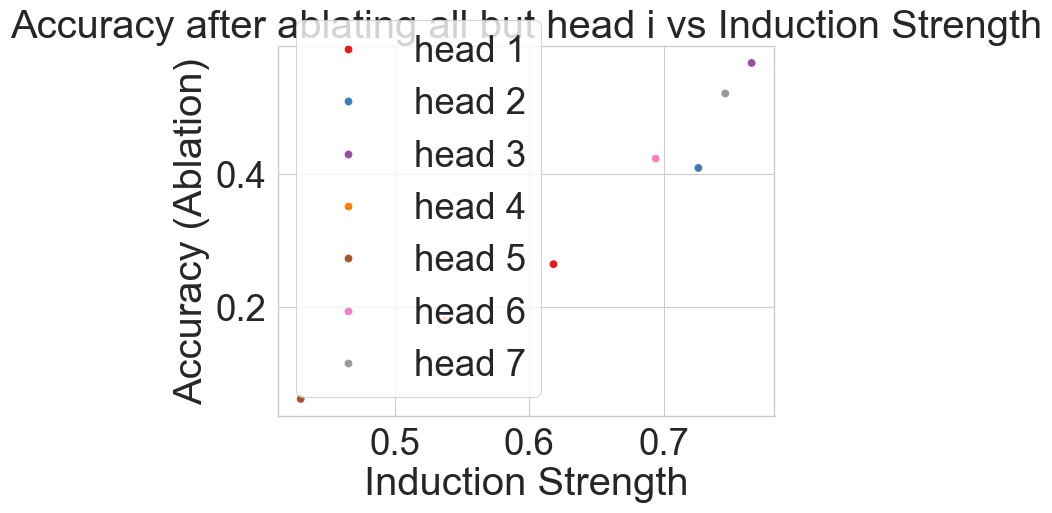

In [16]:
cmap = sns.color_palette('Set1', n_colors=config.model.n_heads)

inds2plot = [v for k, v in induction_strengths_dict.items() if k != 4]
accs2plot = [v for k, v in accuracy_ablation.items() if k != 4]
scatter = plt.scatter(inds2plot, accs2plot, c=np.arange(1,config.model.n_heads), cmap='Set1')
plt.legend([f'head {i}' for i in range(config.model.n_heads)])

plt.legend(handles=scatter.legend_elements()[0], labels=[f'head {i}' for i in range(1, config.model.n_heads)])

plt.xlabel('Induction Strength')
plt.ylabel('Accuracy (Ablation)')
plt.title('Accuracy after ablating all but head i vs Induction Strength')

In [17]:
# now with ablating single heads

accuracy_ablation_single = {}

for h in range(config.model.n_heads):
    head_mask = torch.ones(config.model.n_heads)
    head_mask[h] = 0
    y_hat, out_dict = model(test_inputs_TI, save_weights=config.save_weights, head_mask=head_mask)
    loss = criterion(y_hat, torch.argmax(test_labels_TI.float(), dim=-1))
    predicted_labels = torch.argmax(y_hat, dim=1)
    accuracy = (predicted_labels == torch.argmax(test_labels_TI.float(), dim=-1)).float().mean()
    accuracy_ablation_single[h] = accuracy


Text(0.5, 1.0, 'Accuracy after ablating  vs Induction Strength')

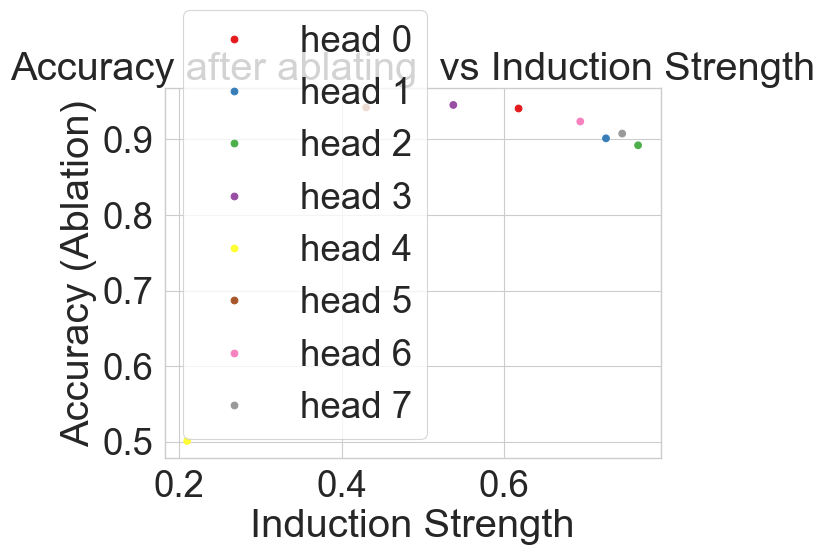

In [18]:

inds2plot = [induction_strengths_dict[i] for i in range(config.model.n_heads)]
accs2plot = [accuracy_ablation_single[i] for i in range(config.model.n_heads)]
scatter = plt.scatter(inds2plot, accs2plot, c=np.arange(config.model.n_heads), cmap='Set1')
plt.legend([f'head {i}' for i in range(config.model.n_heads)])

plt.legend(handles=scatter.legend_elements()[0], labels=[f'head {i}' for i in range(config.model.n_heads)])

plt.xlabel('Induction Strength')
plt.ylabel('Accuracy (Ablation)')
plt.title('Accuracy after ablating  vs Induction Strength')

# Now test the model on all symbolic distances

In [19]:
accuracy_ablation_single

{0: tensor(0.9410),
 1: tensor(0.9015),
 2: tensor(0.8923),
 3: tensor(0.9457),
 4: tensor(0.5008),
 5: tensor(0.9423),
 6: tensor(0.9238),
 7: tensor(0.9078)}

In [20]:
def generate_input_seqs_TI(mus_label, mus_class, labels_class, S, N, Nmax, eps=0.1, B=0, p_B=0, P=None, p_C=0,
                        flip_labels=False, output_target_labels=False, no_repeats=False, shuffle=True, query_pos=None):

    if query_pos is None:
        random_query = True
    else:
        random_query = False

    e_fac = 1 / np.sqrt(1 + eps ** 2)

    L = mus_label.shape[0]  # number of labels. we could assign a different "bigger than" or "smaller than" label for each specific sequence

    K = mus_class.shape[0]
    D = mus_label.shape[1]

    N_items = 7
    N_pairwise = (N_items - 1) * 2
    seq_len = N_pairwise * 2 + 1

    K_c = 128  # number of classes to draw from in the fewshot sequences
    mus_class_new = np.random.normal(size=(K_c, D // 2)) / np.sqrt(D)
    label_mapping_index = np.random.randint(0, L//2, size=(S, 1))

    if K_c < L or K_c % L != 0:
        print("K > L and K%L == 0 is required")
        return 0

    inputs = np.zeros((S, seq_len, 2 * Nmax + 1 + D))

    item_choices_c = np.array([np.random.choice(np.arange(K_c), size=N_items, replace=False) for _ in range(S)])

    item_1_choices_c = np.concatenate([item_choices_c[:, :-1], item_choices_c[:, 1:]], axis=-1)
    item_2_choices_c = np.concatenate([item_choices_c[:, 1:], item_choices_c[:, :-1]], axis=-1)
    label_choices_c = np.tile(np.repeat(np.arange(2), N_pairwise//2), (S, 1))

    converted_label_choices_c = np.zeros_like(label_choices_c)
    converted_label_choices_c = np.where((label_choices_c==1), label_mapping_index, converted_label_choices_c)
    converted_label_choices_c = np.where((label_choices_c==0), label_mapping_index + L//2, converted_label_choices_c)

    random_ordering = np.array([np.random.permutation(N_pairwise) for _ in range(S)])
    item_1_choices_c = item_1_choices_c[np.arange(S)[:, None], random_ordering]
    item_2_choices_c = item_2_choices_c[np.arange(S)[:, None], random_ordering]
    label_choices_c = converted_label_choices_c[np.arange(S)[:, None], random_ordering]

    if random_query:
        targets_c_ind = np.random.choice(item_1_choices_c.shape[1], size=(item_1_choices_c.shape[0],))
        targets_c_1 = item_1_choices_c[np.arange(item_1_choices_c.shape[0]), targets_c_ind]
        targets_c_2 = item_2_choices_c[np.arange(item_1_choices_c.shape[0]), targets_c_ind]
    else:
        # Fixed query positions
        targets_c_1 = item_choices_c[np.arange(item_choices_c.shape[0]), query_pos[0]]
        targets_c_2 = item_choices_c[np.arange(item_choices_c.shape[0]), query_pos[1]]

        # Find the correct index in the shuffled sequence for this specific pair
        targets_c_ind = np.zeros(S, dtype=int)
        for s in range(S):
            # Find where this exact pair appears in the shuffled sequence
            matches = np.where((item_1_choices_c[s] == targets_c_1[s]) &
                             (item_2_choices_c[s] == targets_c_2[s]))[0]
            if len(matches) > 0:
                targets_c_ind[s] = matches[0]
            else:
                # If exact pair not found, this means we need to create it
                # Determine the expected label based on the query order
                if query_pos[1] > query_pos[0]:
                    expected_label = 0  # forward direction
                else:
                    expected_label = 1  # reverse direction

                # Convert to the actual label index
                if expected_label == 1:
                    expected_converted_label = label_mapping_index[s, 0]
                else:
                    expected_converted_label = label_mapping_index[s, 0] + L//2

                # Find a position with the correct label
                label_matches = np.where(label_choices_c[s] == expected_converted_label)[0]
                if len(label_matches) > 0:
                    targets_c_ind[s] = label_matches[0]
                else:
                    # This shouldn't happen if the data is set up correctly
                    print(f"Warning: Could not find appropriate label for query {query_pos}")
                    targets_c_ind[s] = 0

    filt_C = np.random.uniform(size=S) > p_C

    # Fill in the sequences
    inputs[~filt_C, :-1:2, 2 * Nmax + 1:-D//2] = \
    (e_fac * (mus_class_new[item_1_choices_c] + eps * np.random.normal(size=(S, N_pairwise, D//2)) / np.sqrt(D//2)))[~filt_C]
    inputs[~filt_C, :-1:2, 2 * Nmax + 1 + D//2:-1] = \
    (e_fac * (mus_class_new[item_2_choices_c] + eps * np.random.normal(size=(S, N_pairwise, D//2)) / np.sqrt(D//2)))[~filt_C]

    inputs[~filt_C, 1:-1:2, 2 * Nmax + 1:] = ((mus_label[label_choices_c]))[~filt_C]

    inputs[~filt_C, -1, 2 * Nmax + 1:-D//2] = \
    (e_fac * (mus_class_new[targets_c_1] + eps * np.random.normal(size=(S, D//2)) / np.sqrt(D//2)))[~filt_C]
    inputs[~filt_C, -1, 2 * Nmax + 1 + D//2:-1] = \
    (e_fac * (mus_class_new[targets_c_2] + eps * np.random.normal(size=(S, D//2)) / np.sqrt(D//2)))[~filt_C]

    shifts = np.random.choice((2 * Nmax + 1) - seq_len + 1, size=(S))

    labels = np.zeros((S, L), dtype=bool)
    target_classes = np.zeros(S, dtype=int)

    for s in range(S):
        if not filt_C[s]:
            labels[s, label_choices_c[s, targets_c_ind[s]]] = True
            target_classes[s] = -1
        else:
            raise NotImplementedError('This should not happen')

        if shifts[s] + seq_len > 2 * Nmax + 1:
            print('Warning: sequence too long for buffer')
        inputs[s, :, shifts[s]:shifts[s] + seq_len] = np.identity(seq_len)

    # test if sequences is correct (only works for eps=0)
    if eps == 0:
        for s in range(S):
            first_seq = inputs[s][:, 2 * Nmax + 1:]
            if random_query and not np.all(first_seq[:-1] == first_seq[-1], axis=1).sum() == 1:
                print('warning: egeg ')
            target_idx = np.all(first_seq[:-1] ==first_seq[-1], axis=1).argmax()
            target_label = np.all(first_seq[target_idx+1] == mus_label, axis=1).argmax()
            if random_query and not target_label == labels[s].argmax():
                raise ValueError('Target label not found')

    if output_target_labels:
        return np.array(inputs), jnp.array(labels), target_classes
    else:
        return jnp.array(inputs), jnp.array(labels)

In [21]:
def accuracy_to_uncertainty(accuracy):
    # Transform accuracy from [0, 1] to [-1, 1] where 0.5 → 0
    return 2 * (accuracy - 0.5)

In [22]:
ranks = np.arange(0, 7)
acc_mat = np.zeros((len(ranks), len(ranks)))
pred_mat = np.zeros((len(ranks), len(ranks)))
pred_for_target_mat = np.zeros((len(ranks), len(ranks)))
hiddens = []
for i, j in product(ranks, ranks):
    if i == j:
        continue
    test_inputs_TI, test_labels_TI = generate_input_seqs_TI(mus_label, mus_class, labels_class, 1000, N, Nmax, eps=eps,
                                                           B=B, p_B=pB, p_C=pC, no_repeats=no_repeats, query_pos=(i, j))

    test_inputs_TI = torch.from_numpy(np.array(test_inputs_TI)).float()
    test_labels_TI = torch.from_numpy(np.array(test_labels_TI))

    y_hat, out_dict = model(test_inputs_TI, save_weights=config.save_weights, save_hiddens=True)
    hiddens.append(out_dict['hidden_activations_1'])
    # loss = criterion(y_hat, torch.argmax(test_labels_TI.float(), dim=-1))
    predicted_labels = torch.argmax(y_hat, dim=1)
    accuracy = (predicted_labels == torch.argmax(test_labels_TI.float(), dim=-1)).float().mean()

    true_labels = torch.argmax(test_labels_TI.float(), dim=-1)
    # y_hat = torch.softmax(y_hat, dim=-1)

    acc_mat[i, j] = accuracy
    pred_mat[i, j] = y_hat.mean(axis=0)[0]
    pred_for_target_mat[i, j] = accuracy_to_uncertainty(accuracy)

In [23]:
pred_for_target_mat

array([[ 0.        ,  0.94599998,  0.51400006,  0.50600004,  0.41999996,
         0.43799996,  0.88399994],
       [ 0.954     ,  0.        ,  0.84599996, -0.04799998,  0.00600004,
        -0.046     ,  0.35800004],
       [ 0.40199995,  0.87      ,  0.        ,  0.90799999, -0.02999997,
         0.028     ,  0.41199994],
       [ 0.43400002, -0.07599998,  0.89999998,  0.        ,  0.88600004,
        -0.00800002,  0.44599998],
       [ 0.42799997, -0.00999999, -0.042     ,  0.86800003,  0.        ,
         0.86000001,  0.46800005],
       [ 0.36199999, -0.04799998, -0.074     ,  0.03400004,  0.83599997,
         0.        ,  0.94200003],
       [ 0.90799999,  0.42999995,  0.48800004,  0.49000001,  0.41999996,
         0.96200001,  0.        ]])

In [24]:
test_inputs_TI, test_labels_TI = generate_input_seqs_TI(mus_label, mus_class, labels_class, 1000, N, Nmax, eps=eps,
                                                       B=B, p_B=pB, p_C=pC, no_repeats=no_repeats, query_pos=(2, 4))

test_inputs_TI = torch.from_numpy(np.array(test_inputs_TI)).float()
test_labels_TI = torch.from_numpy(np.array(test_labels_TI))

y_hat, out_dict = model(test_inputs_TI, save_weights=config.save_weights, save_hiddens=True)


In [25]:
test_labels_TI[6].float().argmax()

tensor(27)

In [26]:
torch.argmax(test_labels_TI.float(), dim=-1)

tensor([21, 16, 29, 26, 27, 19, 27, 26, 20, 21, 30, 23, 17, 27, 28, 20, 30, 16,
        22, 27, 21, 31, 22, 17, 22, 20, 18, 23, 28, 29, 27, 16, 18, 25, 30, 27,
        23, 28, 27, 27, 31, 17, 21, 19, 18, 25, 20, 22, 16, 30, 22, 20, 23, 27,
        28, 28, 29, 21, 16, 29, 29, 24, 16, 21, 16, 26, 19, 26, 29, 28, 16, 25,
        26, 26, 27, 16, 31, 31, 16, 20, 22, 23, 24, 25, 31, 18, 29, 26, 17, 26,
        30, 16, 31, 29, 20, 28, 22, 23, 18, 25, 17, 30, 23, 23, 29, 17, 23, 25,
        19, 24, 19, 22, 29, 20, 18, 20, 17, 29, 27, 24, 19, 26, 25, 31, 28, 31,
        23, 25, 30, 19, 18, 25, 24, 31, 19, 29, 19, 17, 18, 18, 19, 28, 31, 24,
        17, 18, 19, 24, 20, 17, 22, 29, 23, 22, 20, 17, 22, 28, 22, 29, 22, 22,
        26, 20, 16, 28, 22, 20, 22, 21, 18, 20, 28, 16, 18, 23, 27, 31, 23, 19,
        29, 21, 16, 25, 30, 17, 19, 28, 24, 19, 23, 21, 24, 22, 31, 30, 17, 25,
        26, 31, 26, 20, 16, 18, 16, 19, 16, 26, 16, 26, 24, 28, 25, 26, 27, 16,
        17, 31, 20, 31, 18, 18, 30, 18, 

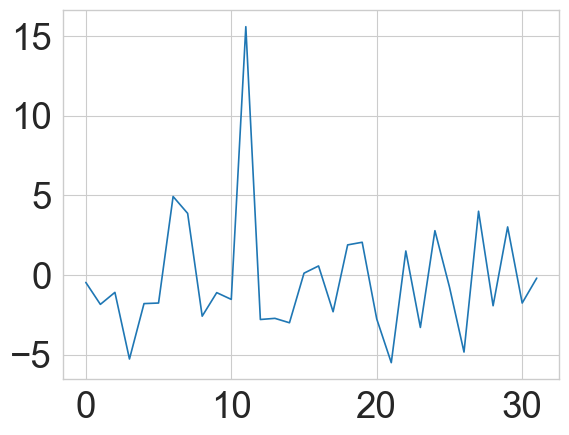

In [27]:
predicted_labels = torch.argmax(y_hat, dim=1)
plt.plot(y_hat[6].detach())

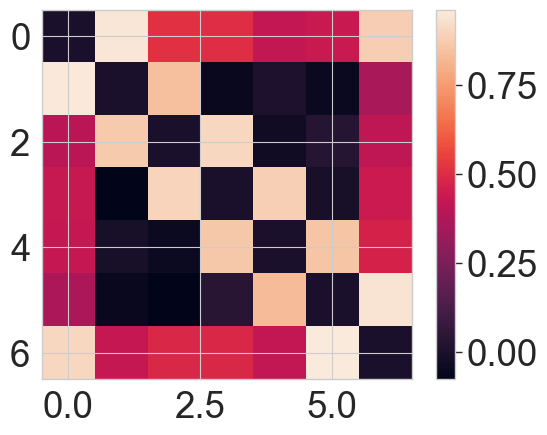

In [28]:
plt.imshow(pred_for_target_mat);plt.colorbar()

In [29]:
pred_mat

array([[ 0.        ,  0.27956691,  0.26832804, -0.16770396, -0.12520427,
        -0.14565338,  0.12269169],
       [-0.28905818,  0.        ,  0.08758122, -0.1627226 , -0.23801365,
        -0.05623161,  0.03330277],
       [-0.25118026, -0.34868997,  0.        ,  0.22775592, -0.01713343,
        -0.11961298,  0.01828965],
       [-0.35946295, -0.1174058 , -0.18805552,  0.        ,  0.15632772,
        -0.16763571, -0.01582824],
       [-0.29667872, -0.25956517, -0.14518082, -0.41836718,  0.        ,
         0.11652101, -0.07373384],
       [-0.48790061, -0.12404927, -0.28156531, -0.17136322, -0.35697678,
         0.        ,  0.32227784],
       [-0.45409736, -0.33645517, -0.44527039, -0.27039668, -0.3111192 ,
        -0.27220181,  0.        ]])

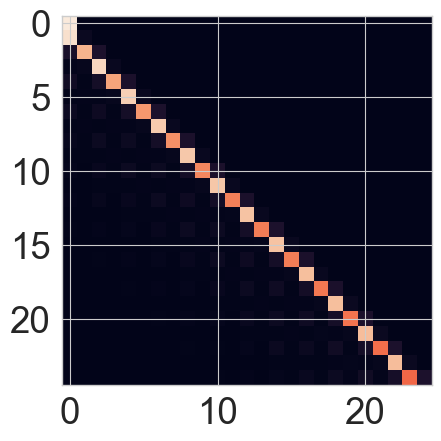

In [30]:
plt.imshow(out_dict['block_0']['weights'].mean(axis=0)[4].detach().numpy())

3


<Axes: title={'center': 'Model Predictions by Symbolic Distance'}, xlabel='Query Pair', ylabel='Prediction Value'>

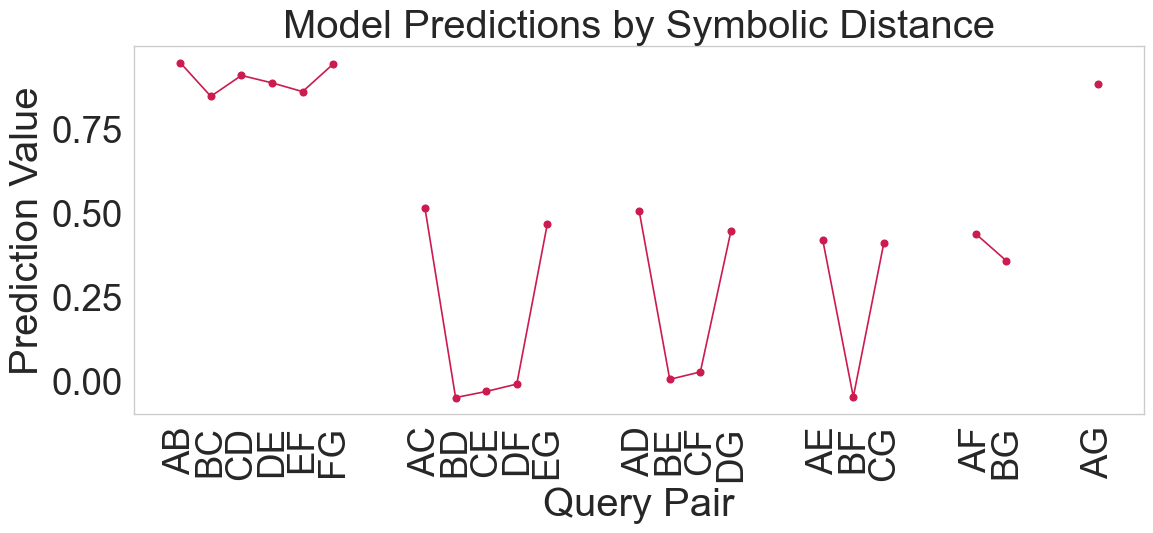

In [31]:
TI_per_pair_plot(pred_for_target_mat)

In [32]:
len(hiddens)

42

In [33]:
item_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']  # Replace with your actual ranks

# Generate the labels for off-diagonal elements
labels = []
symb_distance = []
for i, j in product(ranks, ranks):
    if i == j:
        continue

    label = item_labels[i] + item_labels[j]  # Concatenate to form labels like 'AB', 'AC', etc.
    labels.append(label)
    symb_distance.append(i-j)


In [34]:
final_token_activations = [h.mean(axis=0)[-1] for h in hiddens]

final_token_activations = np.array([np.array(h) for h in final_token_activations])

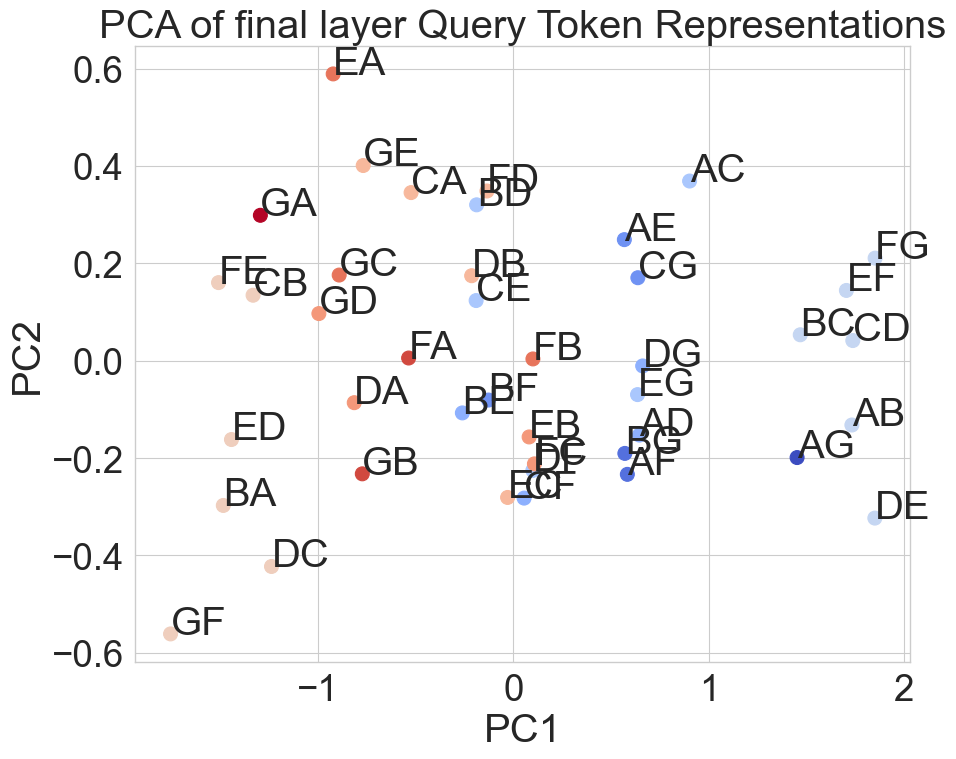

In [35]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(final_token_activations)  # Shape: [P, 2]

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=symb_distance, cmap='coolwarm', s=100)

# Add labels for each point
for i, inp in enumerate(labels):
    plt.annotate(inp, (X_pca[i, 0], X_pca[i, 1]))

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of final layer Query Token Representations')
plt.grid(True)
plt.show()


<Axes: xlabel='iter'>

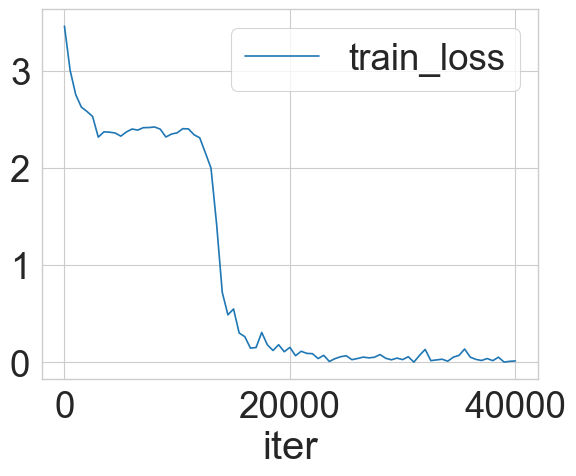

In [36]:
# make full subplots
from definitions import ROOT_FOLDER
import pandas as pd

data_dir = os.path.join(ROOT_FOLDER, 'forpaper')
df = pd.read_csv(os.path.join(data_dir, 'train_loss.csv'))

# Assuming your dataframe is called df
prefix = 'cat_I40001_K1024_N12_L32_D63_a0.0_B1_pB1.0_pC1.0_eps0_lr0.01_drop0.0_custom_lnFalse_wDecay1e-07_adam - '

# Create a mapping for renaming columns
rename_dict = {}
for col in df.columns:
    if col != 'iter' and col.startswith(prefix):
        rename_dict[col] = col.replace(prefix, '')

# Apply the renaming
loss_df = df.rename(columns=rename_dict)

loss_df.plot(x='iter', y='train_loss')


<Axes: xlabel='iter'>

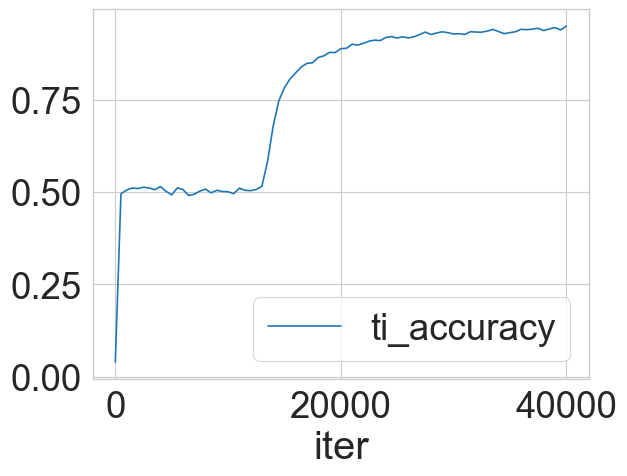

In [37]:
df = pd.read_csv(os.path.join(data_dir, 'ti_accuracy.csv'))

# Assuming your dataframe is called df
prefix = 'cat_I40001_K1024_N12_L32_D63_a0.0_B1_pB1.0_pC1.0_eps0_lr0.01_drop0.0_custom_lnFalse_wDecay1e-07_adam - '

# Create a mapping for renaming columns
rename_dict = {}
for col in df.columns:
    if col != 'iter' and col.startswith(prefix):
        rename_dict[col] = col.replace(prefix, '')

# Apply the renaming
acc_df = df.rename(columns=rename_dict)
acc_df.plot(x='iter', y='ti_accuracy')

3


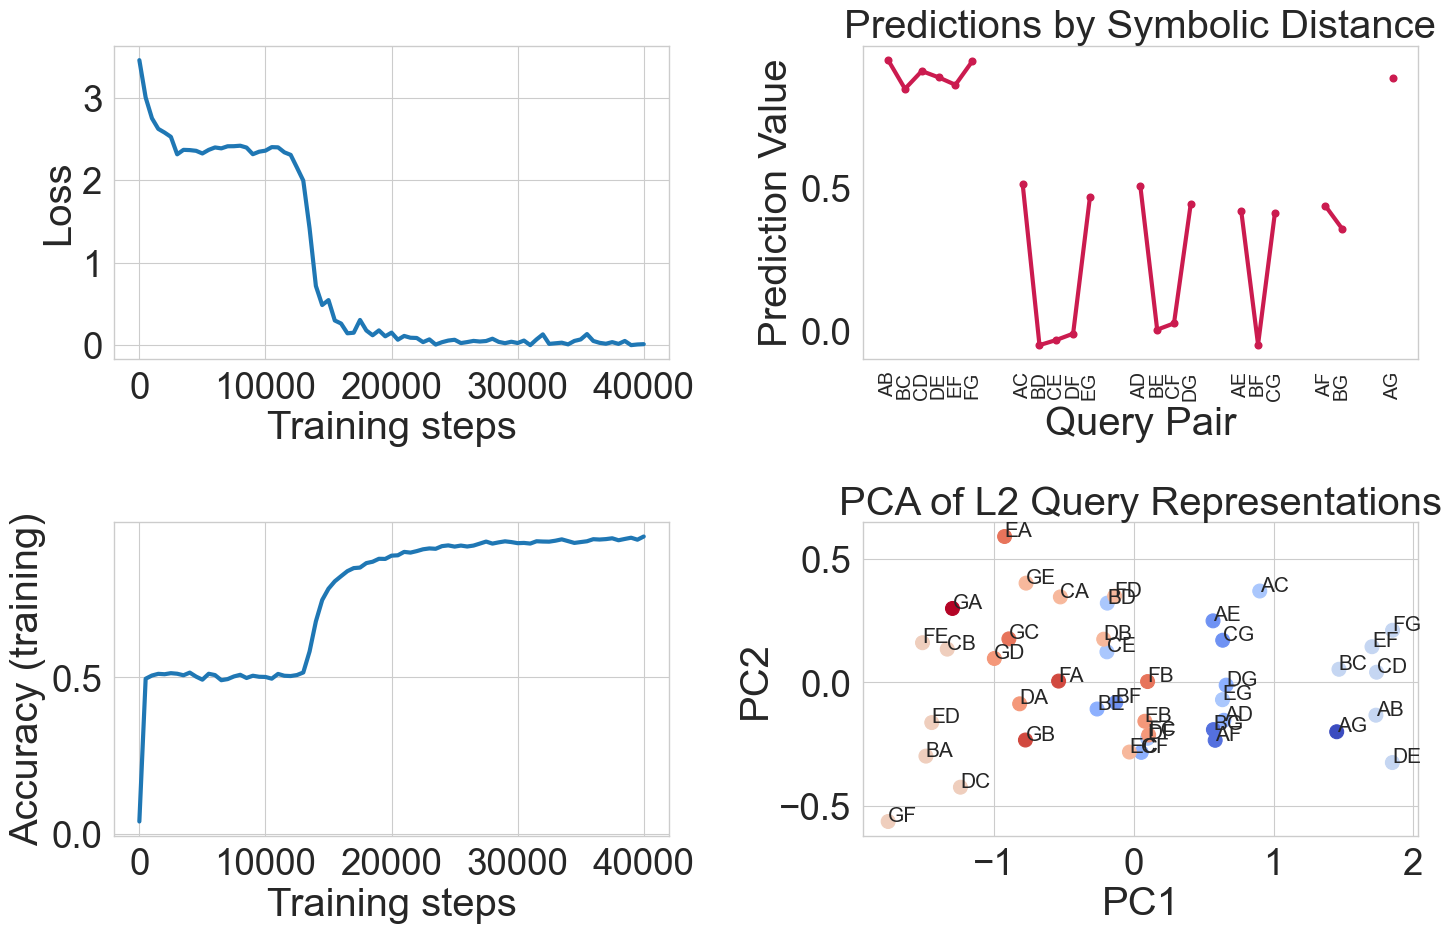

In [38]:
# sns.set_context("paper", font_scale=2.1)
sns.set_context("paper", font_scale=3, rc={"lines.linewidth": 3})

iters = loss_df['iter'].values

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

axs[0].plot(iters, loss_df['train_loss'])
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Training steps')


TI_per_pair_plot(pred_for_target_mat, ax=axs[1])
axs[1].tick_params(axis='x', labelsize=14)  # x-axis tick labels
axs[1].set_title('Predictions by Symbolic Distance')

axs[2].plot(iters, acc_df['ti_accuracy'])
axs[2].set_ylabel('Accuracy (training)')
axs[2].set_xlabel('Training steps')

plt.sca(axs[3])
axs[3].scatter(X_pca[:, 0], X_pca[:, 1], c=symb_distance, cmap='coolwarm', s=100)

# Add labels for each point
for i, inp in enumerate(labels):
    plt.annotate(inp, (X_pca[i, 0], X_pca[i, 1]), fontsize=15)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of L2 Query Representations')

for ax in axs:
    if ax is axs[1]:
        continue
    plt.sca(ax)
    plt.grid('True')

plt.tight_layout()

plt.savefig('ic_transinf.pdf')

In [39]:
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by PC1: {explained_variance[0]:.4f} ({explained_variance[0]*100:.2f}%)")
print(f"Variance explained by PC2: {explained_variance[1]:.4f} ({explained_variance[1]*100:.2f}%)")
print(f"Total variance explained: {sum(explained_variance):.4f} ({sum(explained_variance)*100:.2f}%)")



Variance explained by PC1: 0.7137 (71.37%)
Variance explained by PC2: 0.0430 (4.30%)
Total variance explained: 0.7567 (75.67%)


# plotting the attention weights

In [40]:
data_dir = os.path.join(ROOT_FOLDER, 'forpaper')

df = pd.read_csv(os.path.join(data_dir, 'induction_strength.csv'))

# Assuming your dataframe is called df
prefix = 'cat_I40001_K1024_N12_L32_D63_a0.0_B1_pB1.0_pC1.0_eps0_lr0.01_drop0.0_custom_lnFalse_wDecay1e-07_adam - '

# Create a mapping for renaming columns
rename_dict = {}
for col in df.columns:
    if col != 'iter' and col.startswith(prefix):
        rename_dict[col] = col.replace(prefix, '')

# Apply the renaming
df = df.rename(columns=rename_dict)

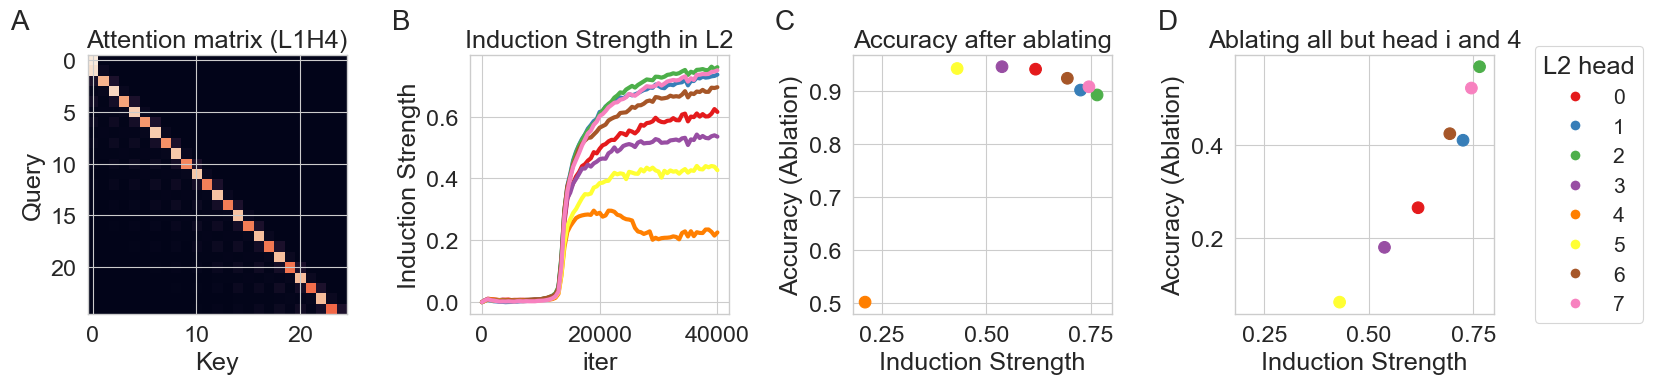

In [41]:
import string

marker_s = 70

sns.set_context("paper", font_scale=1.9, rc={"lines.linewidth": 3})
colors = sns.color_palette("Set1", n_colors=config.model.n_heads)

fig, axs = plt.subplots(1, 4, figsize=(15, 5), )

axs[0].imshow(out_dict['block_0']['weights'].mean(axis=0)[4].detach().numpy())
axs[0].set_title('Attention matrix (L1H4)')
axs[0].grid('False')
axs[0].set_xlabel('Key')
axs[0].set_ylabel('Query')

cols = [f'induction_strength_TI_head_{i}' for i in range(config.model.n_heads)]
axs[1].set_box_aspect(1)
df.plot(x='iter', y=cols, ax=axs[1], legend=False, color=colors)
axs[1].set_ylabel('Induction Strength')
axs[1].set_title('Induction Strength in L2')
axs[1].grid('True')

axs[2].set_box_aspect(1)
plt.sca(axs[2])
inds2plot = [induction_strengths_dict[i] for i in range(config.model.n_heads)]
accs2plot = [accuracy_ablation_single[i] for i in range(config.model.n_heads)]
scatter = plt.scatter(inds2plot, accs2plot, c=colors, s=marker_s)
axs[2].grid('True')
axs[2].set_xlim(0.18, 0.8)

plt.xlabel('Induction Strength')
plt.ylabel('Accuracy (Ablation)')
plt.title('Accuracy after ablating')


inds2plot = [induction_strengths_dict[i] for i in range(config.model.n_heads) if i != 4]
accs2plot = [accuracy_ablation[i] for i in range(config.model.n_heads) if i != 4]
axs[3].set_box_aspect(1)
axs[3].grid('True')
axs[3].set_xlim(0.18, 0.8)
plt.sca(axs[3])
scatter2 = plt.scatter(inds2plot, accs2plot, c=[c for i, c in enumerate(colors) if i != 4], s=marker_s)


plt.xlabel('Induction Strength')
plt.ylabel('Accuracy (Ablation)')
plt.title('Ablating all but head i')


# plt.legend([f'head {i}' for i in range(config.model.n_heads)])

# plt.legend(handles=scatter.legend_elements()[0], labels=[f'head {i}' for i in range(1, config.model.n_heads)])

plt.xlabel('Induction Strength')
plt.ylabel('Accuracy (Ablation)')
plt.title('Ablating all but head i and 4')
legend_labels = [str(i) for i in range(config.model.n_heads)]
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=8)
                   for label, color in zip(legend_labels, colors)]

# Add legend to the right of the rightmost plot
legend = fig.legend(handles=legend_elements,
                    title='L2 head',
                    loc='center left',
                    bbox_to_anchor=(1.02, 0.5),  # Position to the right
                    frameon=True,
                    fontsize='small',  # Smaller font
                    title_fontsize='medium',
                    ncol=1)  # Single column

plt.tight_layout()
# Make room for the legend on the right
plt.subplots_adjust(right=0.9999)

for n, ax in enumerate(axs):
    ax.text(-0.3, 1.1, string.ascii_uppercase[n], transform=ax.transAxes,
            size=20)


plt.savefig('IC_attention_weights.pdf', bbox_inches='tight')

In [42]:

accuracy_ablation_single

{0: tensor(0.9410),
 1: tensor(0.9015),
 2: tensor(0.8923),
 3: tensor(0.9457),
 4: tensor(0.5008),
 5: tensor(0.9423),
 6: tensor(0.9238),
 7: tensor(0.9078)}

In [43]:
accuracy_ablation

{0: tensor(0.2648),
 1: tensor(0.4097),
 2: tensor(0.5677),
 3: tensor(0.1797),
 4: None,
 5: tensor(0.0620),
 6: tensor(0.4238),
 7: tensor(0.5218)}

In [44]:
[c for i, c in enumerate(colors) if i != 4]

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)]

In [62]:
# do this 10 times

pred_mats = []
n_runs = 4

for run in range(n_runs):
    np.random.seed(run)
    ranks = np.arange(0, 7)
    acc_mat = np.zeros((len(ranks), len(ranks)))
    pred_mat = np.zeros((len(ranks), len(ranks)))
    pred_for_target_mat = np.zeros((len(ranks), len(ranks)))
    hiddens = []
    for i, j in product(ranks, ranks):
        if i == j:
            continue
        test_inputs_TI, test_labels_TI = generate_input_seqs_TI(mus_label, mus_class, labels_class, 1000, N, Nmax, eps=eps,
                                                               B=B, p_B=pB, p_C=pC, no_repeats=no_repeats, query_pos=(i, j))

        test_inputs_TI = torch.from_numpy(np.array(test_inputs_TI)).float()
        test_labels_TI = torch.from_numpy(np.array(test_labels_TI))

        y_hat, out_dict = model(test_inputs_TI, save_weights=config.save_weights, save_hiddens=True)
        hiddens.append(out_dict['hidden_activations_1'])
        # loss = criterion(y_hat, torch.argmax(test_labels_TI.float(), dim=-1))
        predicted_labels = torch.argmax(y_hat, dim=1)
        accuracy = (predicted_labels == torch.argmax(test_labels_TI.float(), dim=-1)).float().mean()

        true_labels = torch.argmax(test_labels_TI.float(), dim=-1)
        # y_hat = torch.softmax(y_hat, dim=-1)

        acc_mat[i, j] = accuracy
        pred_mat[i, j] = y_hat.mean(axis=0)[0]
        pred_for_target_mat[i, j] = accuracy_to_uncertainty(accuracy)
    pred_mats.append(pred_for_target_mat)

In [63]:
from plotting_utils import TI_per_pair_plot_with_confidence_intervals

Statistical Summary for TI per pair plot:
Number of runs: 4
Confidence level: 95.0%
Degrees of freedom: 3
t-critical value: 3.182
Error bars represent: Standard Error of the Mean × t-critical
Assumptions: Normally distributed errors across runs


<Axes: title={'center': 'ICL model'}, xlabel='Query Pair', ylabel='Prediction Value'>

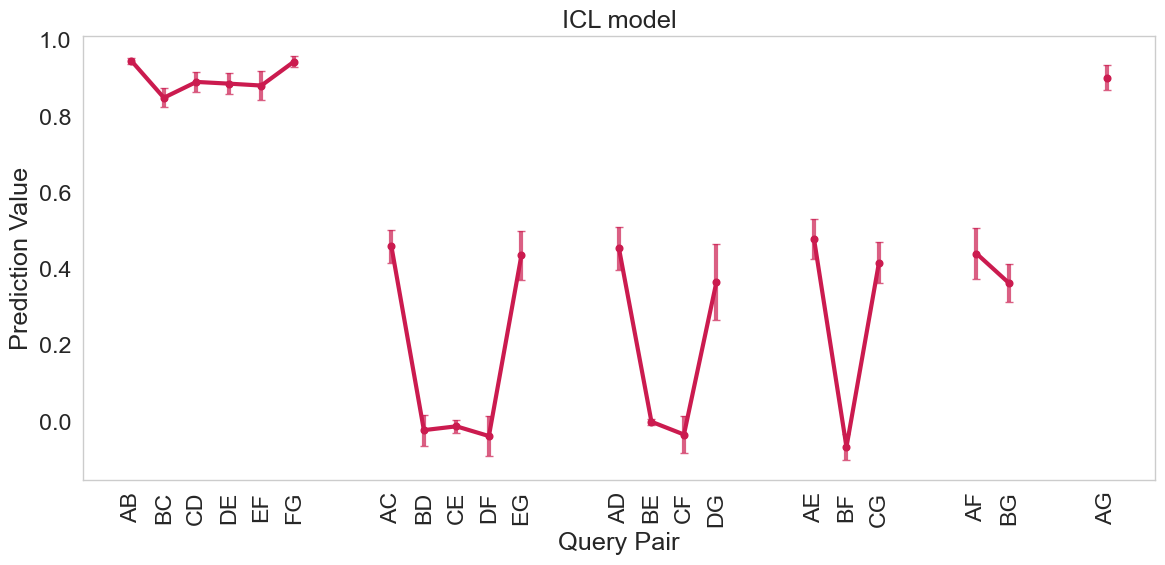

In [67]:
np.save('pred_mats_10runs_icl.npy', np.array(pred_mats))
TI_per_pair_plot_with_confidence_intervals(pred_mats, title='ICL model')